In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import pickle
import time
import sys
from collections import Counter
from scipy.special import expit, logit

import sys
import numpy as np
import pylab as pl
import pandas as pd
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import sklearn.metrics as met
from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# ==================== Define functions ====================

def Extract_Features(PD, Type = 'Full_Cov'): # Functions that only extract interesting features, remove unrelated columns in the pandas dataframe
    # Input PD is the entire pandas dataframe read from csv (result from Rds files of R)
    # Type is an approach that you want to run
    #   - Full_Cov: Keep all features --> remove x-y coordinates and FOI column
    #   - Only_Bio: Only keep Bioclimatic Features --> remove x-y coordinates, FOI column, and other not-bioclimatic columns
    # Output is an pandas dataframe containing only interesting features columns
    # Note: You need to check the names of columns that you want to remove
    
    if (Type == 'Full_Cov'):
        # Full Covariates --> Using all covariates --> remove x-y coordinates and FOI values columns (keep all features)
        if ('FOI' in PD.columns): # This check is for Endemic dataframe since it does not have FOI column    
            Interest_Features = PD.drop(['x', 'y', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y'], axis = 1)
    else:
        # Only Bio Covariates --> Only using bioclimatic --> remove x-y coordinates, FOI columns, and other columns that are not bioclimatic
        if ('FOI' in PD.columns): 
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD', 'FOI'], axis = 1)
        else:
            Interest_Features = PD.drop(['x', 'y', 'DG_000_014bt_dens', 'Elv', 'Pigs', 'Pop_Count_WP_SEDAC_2015', 'Rice', 'UR', 'VD'], axis = 1)
    return Interest_Features

np.random.seed(5) # set seed to regenerate the same random result


# ==================== Set up parameters and Read data ====================

Typemodel = 'Full_Cov' # if Full Cov model --> More detail in above Extract_Features functions
#Typemodel = 'Only_Bio' # if only bio model 

Train_Portion = 0.7 # Portion of Train - Validate - Test
Validate_Portion = (1 - Train_Portion) / 2

resolution_grid = 400
Name_Grid_File = 'Grid_' + str(resolution_grid) + '_' + str(resolution_grid) + '.csv'

print('[Type Model] You have chosen ' + Typemodel)

CurDir = os.getcwd() + '/'
Data_All = CurDir + 'Generate/Python_CSV/EM_Imputed_Features_Study.csv' # 'Directory/to/your/EM_Imputed_Features_Study.csv'
Grid = CurDir + 'Generate/Grids_CSV/' + Name_Grid_File # 'Directory/to/your/Grid/' + Name_Grid_File
Data_EndemicDF = CurDir + 'Generate/Python_CSV/Imputed_Features_Endemic.csv' # 'Directory/to/your/Imputed_Features_Endemic.csv'

# Directory to the folder that you want this script exports files to (remember to have slash '/' at the end)
# Default is to create a subfolder named Python_Export and save result to that subfolder   
Savepath = CurDir + 'Generate/Python_Export/' 
if not os.path.exists(Savepath):
    os.makedirs(Savepath)

# Read csv and store in dataframe in pandas
AllData = pd.read_csv(Data_All)
Grid = pd.read_csv(Grid)  
EndemicDF = pd.read_csv(Data_EndemicDF)
EndemicDF = EndemicDF.drop(['FOI'], axis = 1) # remove FOI column (if it has)

# Remove Pop_2015 density (if wanted, since already have Pop_Count people) --> Check feature name again
# AllData = AllData.drop(['Pop_2015'], axis = 1)
# EndemicDF = EndemicDF.drop(['Pop_2015'], axis = 1)

# Check if matching coordinator
if (len(AllData.iloc[:, :2].merge(Grid.iloc[:, :2])) == len(AllData.iloc[:, :2])):
    print('[Checking Calibration] Matched Coordinators')
    # Recreate grid to match with AllData in case of nrow of 2 dataframe is different
    t = pd.merge(AllData.iloc[:, : 2].reset_index(), Grid.iloc[:, : 2].reset_index(), on=['x','y'], suffixes=['_1','_2'])
    Grid = Grid.iloc[t['index_2'], :]
    del t
else:
    sys.exit('[Stop Program] Grid and Data File do not match coordinators --> Check again')


# ==================== Sampling Grids to define which Grids will be for Train-Validate-Test ====================

# Count freq of pix in each grid
Grid_column = Grid.iloc[:, 2]
Grid_column = np.array(Grid_column)
d = Counter(Grid_column)
grid_freq = np.array(list(d.values())) # number of pix in each grid_numb (belowed)
grid_numb = np.array(list(d.keys()))
del d

# ----- Preprocessing for Sampling train and validate -----
idx_grid_numb_less = np.where(grid_freq < 100)[0] # find idx of grid containing less than 100 pix --> these grids will be automaticly in training set
idx_grid_numb_high = np.where(grid_freq >= 100)[0] # find idx of grid containing more than 100 pix --> these grids will be randomly chosen for training

grid_numb_train_1 = grid_numb[idx_grid_numb_less]
grid_numb_sample = grid_numb[idx_grid_numb_high]

ngrid_train_2 = round(len(grid_numb_sample)*0.7) # 70% train --- 30% test (validate)
ngrid_validate = round(len(grid_numb_sample)*0.15)
ngrid_test = len(grid_numb_sample) - ngrid_train_2 - ngrid_validate
ngrid_train = len(grid_numb_train_1) + ngrid_train_2

print('[Sampling Grid] Training Grids: ' + str(ngrid_train) + ' ----- Validating Grids: ' + str(ngrid_validate) + ' ----- Testing Grids: ' + str(ngrid_test))

print('===== Sampling Model =====')    
grid_numb_sample_shuffle = np.copy(grid_numb_sample)
np.random.shuffle(grid_numb_sample_shuffle)
grid_numb_train_2 = grid_numb_sample_shuffle[:ngrid_train_2]
grid_numb_validate = grid_numb_sample_shuffle[ngrid_train_2:(ngrid_train_2 + ngrid_validate)]
grid_numb_test = grid_numb_sample_shuffle[(ngrid_train_2 + ngrid_validate):]
grid_numb_train = np.append(grid_numb_train_1, grid_numb_train_2)
del grid_numb_sample_shuffle, grid_numb_train_2

# ----- Take index of pixel for each sub-dataset
idx_train = np.where(np.in1d(Grid_column, grid_numb_train))[0]
idx_validate = np.where(np.in1d(Grid_column, grid_numb_validate))[0]
idx_test = np.where(np.in1d(Grid_column, grid_numb_test))[0]

Type = np.zeros(AllData.shape[0])
Type[idx_train] = 1 # index 1 for train
Type[idx_validate] = 2 # index 2 for validate
Type[idx_test] = 3 # index 3 for validate

# Saving Sampling Grid index having 3 columns: x-y coordinates, and Grid index
Coor_Grid_Index = AllData.iloc[:, 0:2]
Coor_Grid_Index = Coor_Grid_Index.assign(Type = pd.Series(Type).values)
filename_grid = 'Grid_Index_' + str(resolution_grid) + '.csv'
print('[Saving] Save Grid Index')
Coor_Grid_Index.to_csv(Savepath + filename_grid, sep='\t', encoding='utf-8')
print('[Saving] Done Saving Grid Index')


# ==================== Create Train-Validate-Test dataset ====================

# ===== Prepare Train =====
Train = AllData.iloc[idx_train, :]
row_na = Train.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Training containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Train)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Train) * 100, 2)) + '%')
Train_Non_NA = Train.drop(Train.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_train = Extract_Features(Train_Non_NA, Typemodel)
Y_train = Train_Non_NA.FOI
Y_train = np.array(Y_train)

# ===== Prepare Validate =====
Validate = AllData.iloc[idx_validate, :]
row_na = Validate.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Validating containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Validate)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Validate) * 100, 2)) + '%')
Validate_Non_NA = Validate.drop(Validate.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_validate = Extract_Features(Validate_Non_NA, Typemodel)
Y_validate = Validate_Non_NA.FOI
Y_validate = np.array(Y_validate)

# ===== Prepare Test =====
Test = AllData.iloc[idx_test, :]
row_na = Test.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total Testing containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(Test)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(Test) * 100, 2)) + '%')
Test_Non_NA = Validate.drop(Test.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_test = Extract_Features(Test_Non_NA, Typemodel)
Y_test = Test_Non_NA.FOI
Y_test = np.array(Y_test)

# ===== Prepare EndemicDF =====
row_na = EndemicDF.isnull().any(1) # check whether a row contains NA or not
#idx_row_na = row_na.nonzero()[0] # find index of row containing NA
#SJ: AttributeError: 'Series' object has no attribute 'nonzero'. This method is deprecated. See below
idx_row_na = row_na.to_numpy().nonzero()[0] # find index of row containing NA

print('[Preprocessing] Total EndemicDF containing NA: ' + str(len(idx_row_na)) + ' / ' + str(len(EndemicDF)) + ' ----- ' + 
      str(round(len(idx_row_na) / len(EndemicDF) * 100, 2)) + '%')
EndemicDF_Non_NA = EndemicDF.drop(EndemicDF.index[idx_row_na]) # remove row containing NA

# ----- Extract Features for model -----
X_endemic = Extract_Features(EndemicDF_Non_NA, Typemodel)


[Type Model] You have chosen Full_Cov
[Checking Calibration] Matched Coordinators
[Sampling Grid] Training Grids: 166 ----- Validating Grids: 30 ----- Testing Grids: 30
===== Sampling Model =====
[Saving] Save Grid Index
[Saving] Done Saving Grid Index
[Preprocessing] Total Training containing NA: 0 / 488914 ----- 0.0%
[Preprocessing] Total Validating containing NA: 0 / 89152 ----- 0.0%
[Preprocessing] Total Testing containing NA: 0 / 123240 ----- 0.0%
[Preprocessing] Total EndemicDF containing NA: 0 / 896827 ----- 0.0%


## PCA

### Data exploration

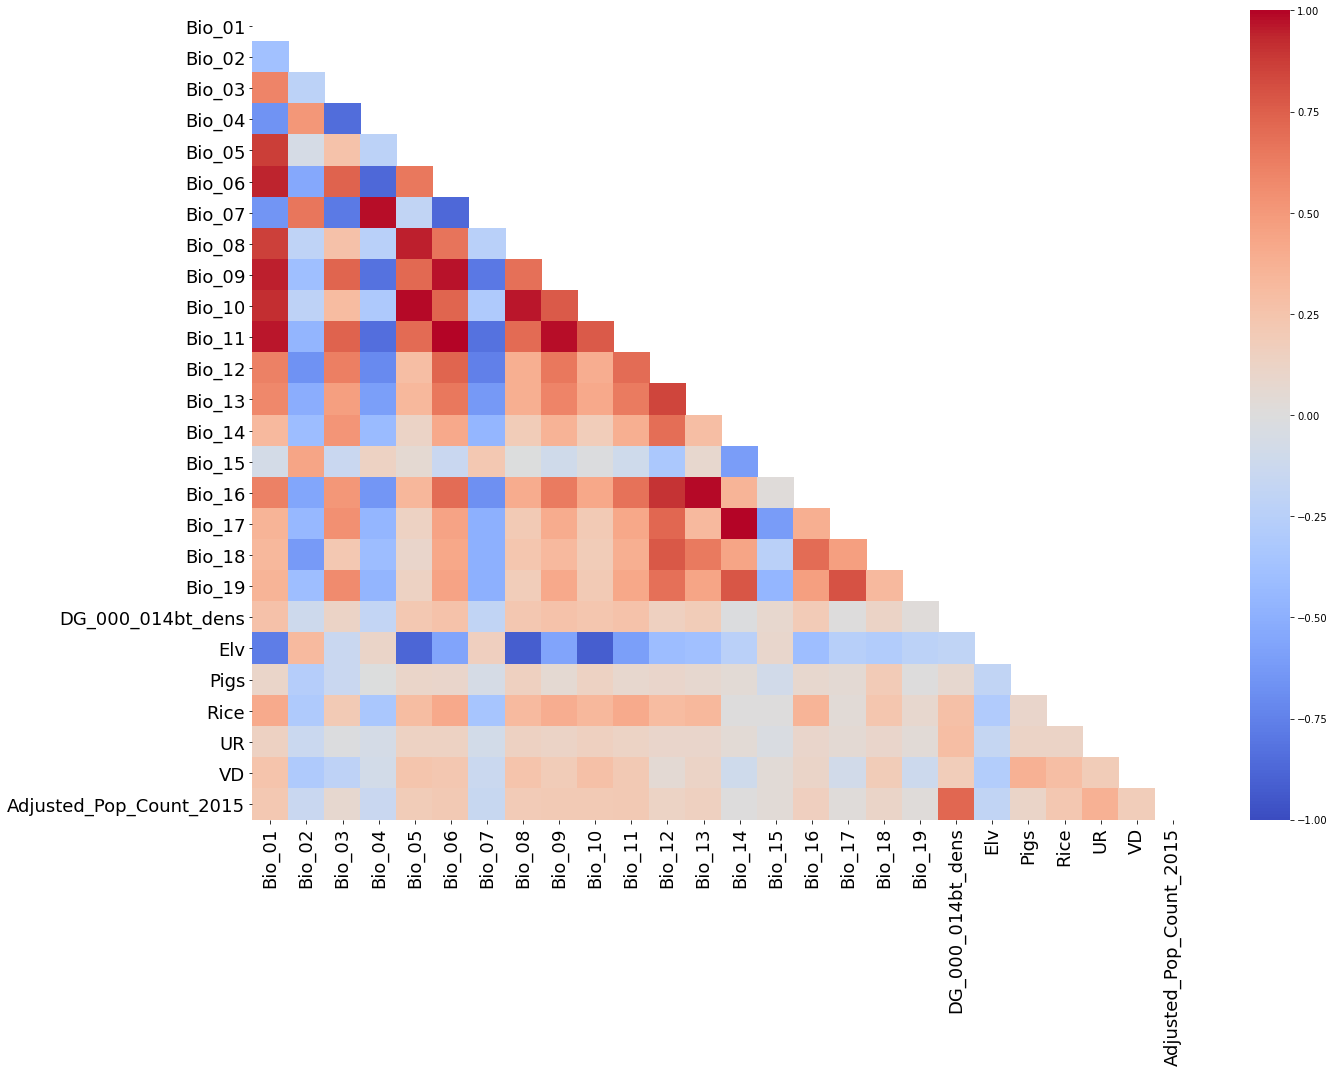

In [2]:
# see if there's evidence of multicolinearity
plt.figure(figsize = (20,15))
matrix = np.triu(X_train.corr())

ax = sns.heatmap(X_train.corr(),mask = matrix, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm')
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
bottom, top = ax.get_ylim()
ax.figure.tight_layout()
ax
ax.figure.savefig('Generate/Python_Export/multicolinearity.png')

[Saving] Save histogram of Y_train


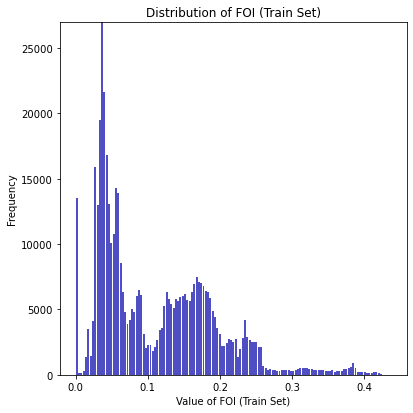

In [3]:
# check distribution of Y_train
plt.figure(figsize = (6,6))
n, bins, patches = plt.hist(x=Y_train, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.xlabel('Value of FOI (Train Set)')
plt.ylabel('Frequency')
plt.title('Distribution of FOI (Train Set)')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.rc('font',size = 15)
plt.rc('axes',labelsize = 15)
plt.tight_layout()

# Save plot 
print('[Saving] Save histogram of Y_train')
filename_plot = 'Histogram.png'
plt.savefig(Savepath + filename_plot)

### PCA step by step

===== Training PCA =====
[Saving] Save cum variance plot
Total variance capturted when using N PCA components:
[0.43402122 0.58073872 0.6632489  0.74107193 0.80113413 0.84791019
 0.87840955 0.90705427 0.93066883 0.95081221 0.96586455 0.97616053
 0.98552177 0.9913636  0.99589578 0.99774618 0.99856533 0.99914197
 0.99955587 0.9997373  0.99985973 0.99993738 0.99998395 0.99999803
 1.         1.        ]


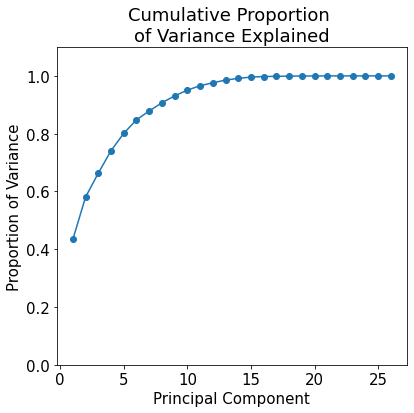

In [4]:
m_name = 'PCA'
print('===== Training PCA =====')

# create/fit the standardized version of X
scaler = sk.preprocessing.StandardScaler()
scaler.fit(X_train)
Z = scaler.transform(X_train)

# create/fit the 'full' pca transformation on Z
pca = PCA().fit(Z)

# pcaZ: the pca-transformed X variables.
pcaZ = pca.transform(Z)

# convert to a data frame
pcaZ_df = pd.DataFrame(pcaZ, columns=[['PCA1' , 'PCA2', 'PCA3', 'PCA4','PCA5', 'PCA6', 'PCA7',\
                                      'PCA8' , 'PCA9', 'PCA10', 'PCA11','PCA12', 'PCA13', 'PCA14',\
                                      'PCA15' , 'PCA16', 'PCA17', 'PCA18','PCA19', 'PCA20', 'PCA21',\
                                      'PCA22' , 'PCA23', 'PCA24', 'PCA25','PCA26']])
# cum variance explained
plt.figure(figsize=(6, 6))
ax = plt.plot(range(1,27),np.cumsum(pca.explained_variance_ratio_),"-o")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance")
plt.title("Cumulative Proportion \nof Variance Explained")
plt.ylim(0,1.1)

plt.rc('font',size = 15)
plt.rc('axes',labelsize = 15)
plt.tight_layout()

# Save plot 
print('[Saving] Save cum variance plot')
filename_var_plot = 'Cumvariance_' + m_name + '_'+ Typemodel + '_' + str(resolution_grid) + '.png'
plt.savefig(Savepath + filename_var_plot)

print("Total variance capturted when using N PCA components:")
print(np.cumsum(pca.explained_variance_ratio_))


## Principal Component Regression

In [5]:
# pcaZ_test: the pca-transformed X_test variables.
pcaZ_test = pca.transform(scaler.transform(X_test))[:,:10]

#Add constant to X_train and x_test (add intercept)
pcaX_train_cst = sm.add_constant(pcaZ[:,:10])
pcaX_test_cst = sm.add_constant(pcaZ_test)

#Training
start_time = time.time()
model = sm.OLS(Y_train, pcaX_train_cst).fit()
end_time = time.time()
print('[Training] Finish training')
training_time = round(end_time - start_time, 5) # seconds
print('Training Time: ' + str(training_time) + ' seconds')

#Predict
Y_pred_train = model.predict(pcaX_train_cst)
Y_pred_test = model.predict(pcaX_test_cst)

#Perfromance Evaluation
train_score = mean_squared_error(Y_train, Y_pred_train)
test_score = mean_squared_error(Y_test, Y_pred_test)

print("Training MSE:",train_score)
print("Testing MSE:",test_score)

# Export csv of MSE
print('[Saving] Save MSE evaluation')        
Result_pd = pd.DataFrame(data = {'mse_train':[train_score], 'mse_test':[test_score], 'time_train':[training_time]})   
filename_mse = 'MSE_' + m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Result_pd.to_csv(Savepath + filename_mse, sep='\t', encoding='utf-8')


[Training] Finish training
Training Time: 0.35878 seconds
Training MSE: 0.0048682791542323965
Testing MSE: 0.00657667436889344
[Saving] Save MSE evaluation


### Prediction performance

In [6]:
# get CI
pred2 = model.get_prediction(pcaX_test_cst)
y_lower_upper = pred2.conf_int() #default = 0.05

# dataframe
dat = np.concatenate((Y_test.reshape(-1,1), 
                      Y_pred_test.reshape(-1,1), 
                      y_lower_upper), axis = 1)
dat = pd.DataFrame(dat, columns = ['y','yhat','lower','upper'])

# sort the dataframe for plotting
dat2 = dat.sort_values('y')

# take 1% and replot the above CI
dat2 = dat2.sample(frac = 0.01, replace = False, random_state = 123)

dat2.head()

,y,yhat,lower,upper
15325,0.136077,0.122218,0.121731,0.122705
81566,0.181975,0.167579,0.167016,0.168143
39935,0.026851,0.044621,0.044099,0.045143
4587,0.153757,0.088902,0.088386,0.089417
71979,0.029554,0.083400,0.082851,0.083950


[Saving] Save thinned CI plot


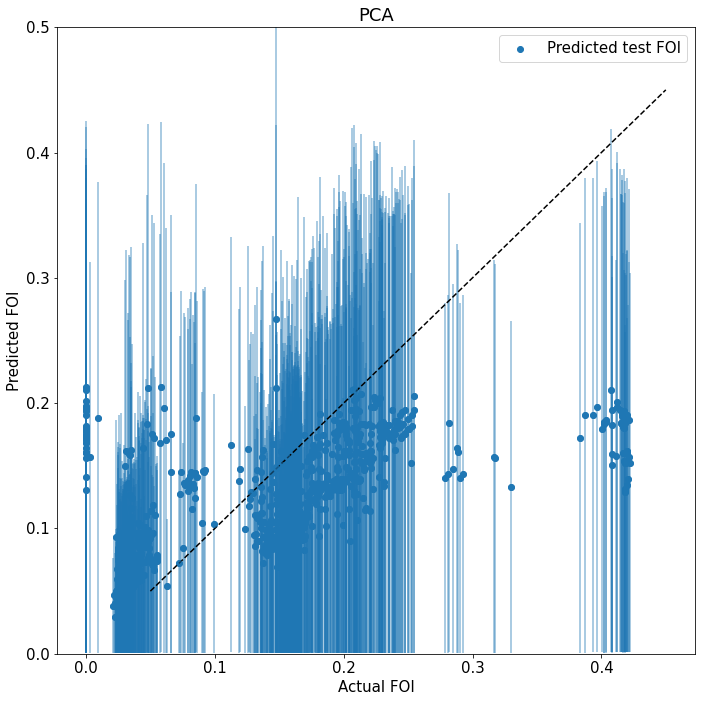

In [7]:
def plotci_3(Y_test, dat2, m_name):
    

    fig, ax = plt.subplots(figsize = (10,10))
    plt.scatter(dat2['y'], dat2['yhat'],label = 'Predicted test FOI')
    plt.errorbar(dat2['y'], dat2['yhat'], np.array(dat2['lower'], dat2['upper']), fmt='o',alpha = 0.5)
    plt.plot([0.05,0.45],[0.05,0.45], 'k--')
    plt.xlabel('Actual FOI')
    plt.ylabel('Predicted FOI')
    plt.ylim(0,0.5)
    plot_name = m_name 
    
    plt.title(plot_name)
    plt.legend()
    
    plt.rc('font',size = 15)
    plt.rc('axes',labelsize = 15)
    plt.tight_layout()

    # Save thinned CI plot 
    print('[Saving] Save thinned CI plot')
    filename_ci_plot = 'CI_'+ m_name + '_' + Typemodel + '_' + str(resolution_grid) + '.png'
    plt.savefig(Savepath + filename_ci_plot)

plotci_3(Y_test, dat2, m_name)


In [8]:
# ----- Export csv of TestDF (Coor and result)
print('[Saving] Save predicted test FOI with coords')
Coor = Test_Non_NA.iloc[:, 0: 2]
Coor = Coor.assign(Actual = pd.Series(Y_test).values,
                   Predict = pd.Series(Y_pred_test).values,
                   Lower = pd.Series(y_lower_upper[:,0]).values,
                   Upper = pd.Series(y_lower_upper[:,1]).values)
filename_test = 'Test_FOI_'+ m_name + Typemodel + '_' + str(resolution_grid) + '.csv'
Coor.to_csv(Savepath + filename_test, sep='\t', encoding='utf-8')

# ----- Predict Endemic FOI
# pcaZ_endem: the pca-transformed X_endemic variables.
pcaZ_endem = pca.transform(scaler.transform(X_endemic))[:,:10]

#Add constant
pcaX_endem_cst = sm.add_constant(pcaZ_endem)

#Predict
Y_pred_endem = model.predict(pcaX_endem_cst)

# get CI
pred_endem = model.get_prediction(pcaX_endem_cst)
y_lower_upper_endem = pred_endem.conf_int() #default = 0.05


# ----- Export csv of EndemicDF (Coor and result)
print('[Saving] Save predicted FOI with coords')
Coor = EndemicDF_Non_NA.iloc[:, 0: 2]
Coor = Coor.assign(Predict = pd.Series(Y_pred_endem).values,
                  Lower = y_lower_upper_endem[:,0],
                  Upper = y_lower_upper_endem[:,1])
filename_endemic = 'Endemic_FOI_PCR_' + Typemodel + '_' + str(resolution_grid) + '.csv'
Coor.to_csv(Savepath + filename_endemic, sep='\t', encoding='utf-8')


[Saving] Save predicted test FOI with coords
[Saving] Save predicted FOI with coords
